<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymupdf requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 31.6 MB/s eta 0:00:00


In [2]:
import os
import requests
import fitz  # PyMuPDF

# Sample arXiv paper IDs related to diffusion models
arxiv_ids = [ "2210.05274",  # Equivariant 3D-Conditional Diffusion Models for Molecular Linker Design
             ]

def download_pdf(arxiv_id, output_folder):
    url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"
    pdf_path = os.path.join(output_folder, f"{arxiv_id}.pdf")
    response = requests.get(url)
    with open(pdf_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded {arxiv_id}")
    return pdf_path

def pdf_to_text(pdf_path, txt_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Converted to text: {txt_path}")


In [3]:
    data_dir = "data"
    os.makedirs(data_dir, exist_ok=True)

    for arxiv_id in arxiv_ids:
        pdf_path = download_pdf(arxiv_id, data_dir)
        txt_path = os.path.join(data_dir, f"{arxiv_id}.txt")
        pdf_to_text(pdf_path, txt_path)

Downloaded 2210.05274
Converted to text: data/2210.05274.txt


In [50]:

def clean_text(text):
    import re

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove LaTeX math expressions
    #text = re.sub(r"$.*?$", "", text)

    # Remove repeated words
    #text = re.sub(r"\b(\w+)( \1\b)+", r"\1", text)

    # Remove special characters
    #text = re.sub(r"[^a-zA-Z0-9.,;:?!\s]", "", text)

    # Pattern for common author name formats
    #pattern = r"\b([A-Z][a-z]+(?: [A-Z][a-z]+)*,? (?:[A-Z]\.)?\b(?: and [A-Z][a-z]+(?: [A-Z][a-z]+)*,? (?:[A-Z]\.)?)+|\b(?:et al\.)\b)"
    # Replace any matched author names with an empty string
    #text = re.sub(pattern, '', text)

    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def clean_text_remove_references(text):
    # Remove extra newlines and empty lines
    text = "\n".join([line.strip() for line in text.splitlines() if line.strip() != ""])

    # Cut off everything after 'References' or 'Bibliography'
    refs_keywords = ["references", "bibliography"]
    for keyword in refs_keywords:
        idx = text.lower().find(keyword)
        if idx != -1:
            text = text[:idx]  # Keep text before the references section
            break

    # Remove sections related to funding or acknowledgments
    text = re.sub(r".*grant agreement.*|.*funding.*|.*acknowledg(e)?ment.*", "", text, flags=re.IGNORECASE)

    return text




RAG:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">



In [5]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 821.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.3 MB/s eta 0:00:00
 

In [6]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import re
pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

In [51]:
from langchain.docstore.document import Document as LangchainDocument

# Read the text file
with open("/content/data/2210.05274.txt", "r", encoding="utf-8") as f:
    text = f.read()

text = clean_text_remove_references(text)
text = clean_text(text)

# Create a list with one LangchainDocument
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=text, metadata={"source": "*.txt"})
]


In [52]:
print(text)

Preprint EQUIVARIANT 3D-CONDITIONAL DIFFUSION MODELS FOR MOLECULAR LINKER DESIGN Ilia Igashov EPFL ilia.igashov@epfl.ch Hannes St¨ark Massachusetts Institute of Technology hstark@mit.edu Cl´ement Vignac EPFL clement.vignac@epfl.ch Victor Garcia Satorras Microsoft Research AI4Science victorgar@microsoft.com Pascal Frossard EPFL pascal.frossard@epfl.ch Max Welling Microsoft Research AI4Science maxwelling@microsoft.com Michael Bronstein University of Oxford michael.bronstein@cs.ox.ac.uk Bruno Correia EPFL bruno.correia@epfl.ch ABSTRACT Fragment-based drug discovery has been an effective paradigm in early-stage drug development. An open challenge in this area is designing linkers between dis- connected molecular fragments of interest to obtain chemically-relevant candi- date drug molecules. In this work, we propose DiffLinker, an E(3)-equivariant 3D-conditional diffusion model for molecular linker design. Given a set of dis- connected fragments, our model places missing atoms in between an

### Load your knowledge base

given a user question, find the most relevant snippets from our knowledge base to answer that question.

How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`.

In [53]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
SEPARATORS = [
    " ",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [54]:
docs_processed[0]

Document(metadata={'source': '*.txt', 'start_index': 0}, page_content='Preprint EQUIVARIANT 3D-CONDITIONAL DIFFUSION MODELS FOR MOLECULAR LINKER DESIGN Ilia Igashov EPFL ilia.igashov@epfl.ch Hannes St¨ark Massachusetts Institute of Technology hstark@mit.edu Cl´ement Vignac EPFL clement.vignac@epfl.ch Victor Garcia Satorras Microsoft Research AI4Science victorgar@microsoft.com Pascal Frossard EPFL pascal.frossard@epfl.ch Max Welling Microsoft Research AI4Science maxwelling@microsoft.com Michael Bronstein University of Oxford michael.bronstein@cs.ox.ac.uk Bruno Correia EPFL bruno.correia@epfl.ch ABSTRACT Fragment-based drug discovery has been an effective paradigm in early-stage drug development. An open challenge in this area is designing linkers between dis- connected molecular fragments of interest to obtain chemically-relevant candi- date drug molecules. In this work, we propose DiffLinker, an E(3)-equivariant 3D-conditional diffusion model for molecular linker design. Given a set of

In [55]:
docs_processed[10]

Document(metadata={'source': '*.txt', 'start_index': 9008}, page_content='Conformer generation methods GeoDiff (Xu et al., 2022) and ConfGF (Shi et al., 2021) condition the model on the adjacency matrix of the molecular graph. Since they have access to the connectivity information, they can compute torsion angles between atoms and optimize them (Jing et al., 2022). Equivariant Diffusion Model (EDM) (Hoogeboom et al., 2022) generates 3D molecules from scratch and is able to be conditioned on the predeﬁned scalar prop- erties. Another diffusion model has been recently proposed for designing protein scaffolds given protein motifs (Trippe et al., 2022). Having the conditional sampling procedure, this model is how- ever trained in an unconditional setup. Finally, Luo et al. (2022) proposed a model for antibody design which combines discrete diffusion for the molecular graphs and continuous diffusion on the 3D coordinates. The conditioning mechanism proposed in this work is the closest to ou

We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

Model's maximum sequence length: 512


  0%|          | 0/40 [00:00<?, ?it/s]

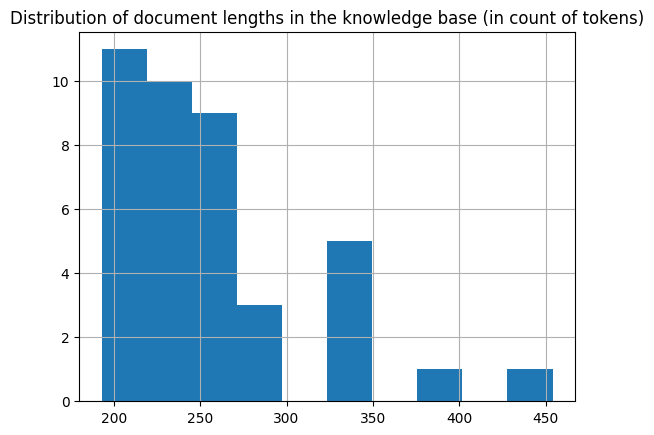

In [56]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - Smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

  0%|          | 0/20 [00:00<?, ?it/s]

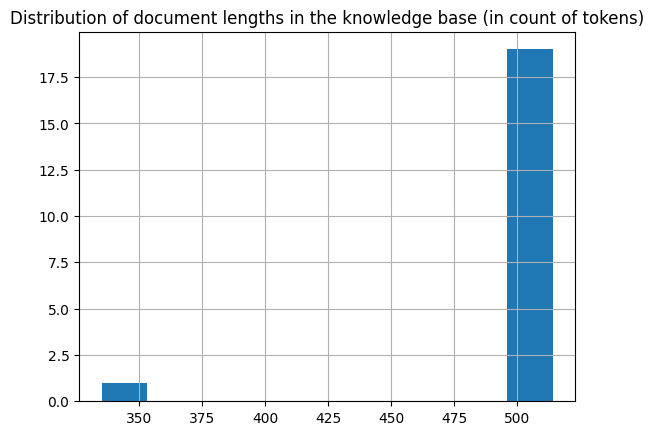

In [57]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

### 1.2 Building the vector database

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

cosine similarity: choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

In [58]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

👀 To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

In [59]:
# Embed a user query in the same space
user_query = "What is diffusion?"
query_vector = embedding_model.embed_query(user_query)

In [60]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [61]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What is diffusion?'...

==================================Top document==================================
point x unknown. The generative transition distribution is deﬁned as: p(zt−1|zt) = q(zt−1|ˆx, zt), (6) where ˆx is an approximation of the data point x computed by a neural network ϕ. Ho et al. (2020) have empirically shown that it works better to predict the Gaussian noise ˆϵt = ϕ(zt, t) instead, and then estimate the data point ˆx using Equation (3): ˆx = (1/αt)zt −(σt/αt)ˆϵt. (7) The neural network is trained to maximize an evidence lower bound to the likelihood of the data under the model. Up to a prefactor that depends on t, this objective is equivalent to the mean squared error between predicted and true noise (Ho et al., 2020; Kingma et al., 2021). We therefore use the simpliﬁed objective L(t) = ||ϵ −ˆϵt||2 that can be optimized by mini-batch gradient descent using an estimator Et∼U(0,...,T )[T · L(t)]. Finally, once the network is trained,

# 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 2.1. Reader model

The choice of a reader model is important in a few aspects:
- the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

For this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

To make inference faster, we will load the quantized version of the model:

In [62]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cuda:0


In [63]:
READER_LLM("What is diffusion? Answer:")

[{'generated_text': ' Diffusion is the movement of molecules from a region of higher concentration to a region of lower concentration until equilibrium is reached. This process occurs spontaneously and does not require any external energy source.\n\nDiffusion is driven by the random motion of molecules, known as Brownian motion. The greater the concentration gradient (the difference in concentration between two regions), the faster the rate of diffusion. Factors that affect the rate of diffusion include temperature, particle size, and solubility.\n\nIn biological systems, diffusion plays a critical role in the transport of nutrients, waste products, and signaling molecules across cell membranes and through extracellular spaces. It also helps to distribute oxygen and carbon dioxide throughout the body during respiration.\n\nOverall, diffusion is a fundamental concept in chemistry and biology, and understanding its principles is essential for many scientific disciplines.'}]

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [64]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents!

In [65]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Can you explain the main result?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The main result presented in this text is the introduction of DiffLinker, a new E(3)-equivariant diffusion model for generating molecular linkers conditioned on 3D fragments. This model is distinguished from other diffusion models for molecule generation in that it is conditioned on three-dimensional data, specifically a fixed context consisting of input fragments and protein pocket atoms. The model operates on point clouds while being conditioned on this context, and the generative process is required to be equivariant to its transformations due to the presence of the 3D context. The paper proposes an appropriate learnable dynamic function and discusses strategies for sampling the size of a linker and conditioning on protein pockets. The full linker generation workflow is outlined in Figure 1 and algorithms for training and sampling are provided.


In [66]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What are the main themes discussed in this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The main themes discussed in this work include:

1. Denoising diffusion probabilistic models for generative modeling of molecular structures and properties, including image generation, audio synthesis, and molecular dynamics simulations.
2. Gaussian noise diffusion process and generative denoising process, with closed-form expressions for the reverse of the diffusion process.
3. Categorical features in molecular diffusion models, addressed through lifting atom types to a continuous space and converting back to discrete values at the end of the denoising process.
4. Equivariance requirements for diffusion models processing 3D molecular structures, including translation invariance, orthogonal group O(3) equivariance, and Euclidean group E(3) equivariance.
5. Introducing DiffLinker, a new E(3)-equivariant diffusion model for generating molecular linkers conditioned on 3D fragments and protein pockets, with strategies for sampling linker sizes and conditioning on protein pockets.
6. Compar

In [67]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How is this work related to other similar journal papers? What similar work precedes it?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The passage mentions several related journal papers, including:

1. "DeLinker: Learning to Disconnect Molecular Bonds" by Hoogeboom et al. (2021) - This paper proposes a diffusion model called DeLinker for disconnecting bonds in molecules. It uses a categorical diffusion model to handle discrete bond types and converts them to continuous values during the denoising process. The final transition distribution involves converting the continuous values back to discrete bond types.

2. "3DLinker: Generating 3D Molecular Linkers via Diffusion Models" by Hoogeboom et al. (2022) - This paper introduces a new E(3)-equivariant diffusion model called 3DLinker for generating 3D molecular linkers. It lifts the discrete bond types to a continuous space and adds Gaussian noise to the resulting continuous values. During the denoising process, the continuous values are converted back to discrete bond types.

3. "Equivariant Diffusion Model for Molecular Generation" by Hoogeboom et al. (2022) - This pap

In [68]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Can you give a literature review of papers with similar conclusions?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Based on the context provided, it is unclear what specific conclusions are being referred to. Please provide more information or clarify which conclusions you are referring to in order for me to provide a relevant literature review. Without further context, it is impossible to accurately identify papers with similar conclusions.


In [69]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What is the speciality of the diffusion model discussed here? How has the method been applied in this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The specialty of the diffusion model discussed in this work is its ability to generate molecular linkers conditioned on 3D fragments and a fixed context, which includes all input fragments and (optionally) protein pocket atoms that remain unchanged throughout the diffusion and denoising processes. This method, called DiffLinker, is an E(3)-equivariant diffusion model that operates on point clouds and is conditioned on three-dimensional data. It differs from other diffusion models for molecule generation in that it is specifically designed for linker generation and takes into account the geometric information of the input fragments and protein pockets. The method involves adding Gaussian noise to a data point iteratively to progressively transform it into the noise, followed by a generative denoising process that approximates the reverse of the diffusion process. The proposed learnable dynamic function ensures equivariance requirements for the underlying denoising distributions. The met

In [70]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What are the limitations of this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The limitations of this work are discussed briefly in Section 5 of the preprint. Some potential limitations mentioned include:

1. Scalability: The current implementation of DiffLinker is limited by the computational cost of the equivariant neural networks used in the model. This may limit its scalability to very large molecules or high-dimensional inputs.

2. Protein pocket modeling: The current version of DiffLinker assumes that the protein pockets remain fixed during the diffusion and denoising processes. However, in reality, protein pockets may change shape and size during ligand binding. Future work could explore ways to incorporate protein pocket dynamics into the model.

3. Linker length sampling: The current version of DiffLinker assumes a fixed linker length, which may not always be optimal for a particular application. Future work could explore ways to incorporate linker length sampling into the model.

4. Generalizability: The current version of DiffLinker is trained on a sp

In [71]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Can you compare this work with some other papers that are similar but not discussed in this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The paper "DiffLinker: EQUIVARIANT 3D-CONDITIONAL DIFFUSION MODEL FOR MOLECULAR LINKER DESIGN" introduces a new E(3)-equivariant diffusion model for generating molecular linkers conditioned on 3D fragments. The authors compare their work with several recent papers in the field of molecular diffusion modeling, including DeLinker (Banich et al., 2021), 3DLinker (Hoogeboom et al., 2022), GeoDiff (Xu et al., 2022), ConfGF (Shi et al., 2021), EDM (Hoogeboom et al., 2022), and a model for antibody design proposed by Luo et al. (2022). However, there are other related papers that are not discussed in this work. Some examples include:

1. "Equivariant Generative Models for Protein Structures" by Batz et al. (2021) proposes a framework for learning equivariant generative models for protein structures using a combination of graph neural networks and continuous diffusion models.

2. "Protein Structure Prediction with Graph Neural Networks" by Jumper et al. (2021) presents a novel approach to prot